# CS 6433 Project 2: Implementing AlexNet

Hongyu Zhai (`hz2162`)

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

## Loading the Dataset

In the original proposal, I planned to use a subset of the ILSVRC2010 training images to train the model. However, the [download link](http://image-net.org/challenges/LSVRC/2010/download-public) no longer works. After consulting Professor Wong, I decided to go with the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Keras provides a function to load CIFAR-100
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode="fine")

Besides loading the images, `load_data` also splits them into the training and testing sets. There are $50000$ training images, $10000$ testing images, each image has the dimension $(32 x 32 x 3)$.

In [3]:
n_test = X_test.shape[0]
n_train = X_train.shape[0]
img_shape = X_train.shape[1:]

print("Number of training examples:", n_train)
print("Number of testing examples:", n_test)
print("Shape of input images:", img_shape)

Number of training examples: 50000
Number of testing examples: 10000
Shape of input images: (32, 32, 3)


To make sure images are properly loaded, we use `matplotlib` to display some images.

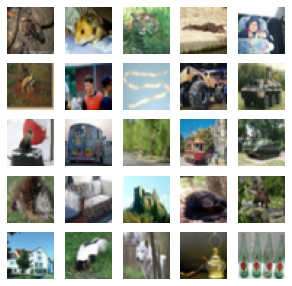

In [4]:
fig, axes1 = plt.subplots(5, 5, figsize=(5, 5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(n_train)
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i:i+1][0])

## Build the AlexNet

Then, we follow the original [paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and build the model layer by layer. There are five convolution layers, followed by three fully connected layers.

### First Convolution Layer

> "The first convolutional layer filters the 224×224×3 input image with 96 kernels of size 11×11×3 with a stride of 4 pixels."

> "The ReLU non-linearity is applied to the output of every convolutional and fully-connected layer."

> "Response-normalization layers follow the first and second convolutional layers."

> "Max-pooling layers, of the kind described in Section 3.4, follow both response-normalization layers as well as the fifth convolutional layer."

The original architecture, which was designed for ImageNet images, assumes the input size to be $224 \times 224 \times 3$. Since we are using much smaller images, we change the input shape to $32 \times 32 \times 3$.

In [5]:
# layer #1 conv #1
l1_conv1 = keras.layers.Conv2D(input_shape=img_shape,
                               filters=96,
                               kernel_size=(11, 11),
                               strides=(4, 4),
                               padding='same',
                               activation='relu')

# response-normalization layer follows the first conv layer
l1_conv1_norm = keras.layers.BatchNormalization()

# max pooling layer with s = 2, and z = 3
l1_conv1_pool = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                          strides=(2,2),
                                          padding='same')

### Second Convolution Layer

> "The second convolutional layer takes as input the (response-normalized and pooled) output of the first convolutional layer and filters it with 256 kernels of size 5 × 5 × 48"

In [6]:
# layer #2 conv #2
l2_conv2 = keras.layers.Conv2D(filters=256,
                               kernel_size=(5, 5),
                               strides=(1, 1), 
                               padding='same',
                               activation='relu')

# response-normalization layer follows the second conv layer
l2_conv2_norm = keras.layers.BatchNormalization()

# max pooling layer with s = 2, and z = 3
l2_conv2_pool = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                          strides=(2, 2),
                                          padding='same')

### Third Convolution Layer

> "The third, fourth, and fifth convolutional layers are connected to one another without any intervening pooling or normalization layers."

> "The third convolutional layer has 384 kernels of size 3 × 3 × 256 connected to the (normalized, pooled) outputs of the second convolutional layer."

In [7]:
# layer #3 conv #3
l3_conv3 = keras.layers.Conv2D(filters=384,
                               kernel_size=(3, 3),
                               strides=(1, 1), 
                               padding='same',
                               activation='relu')

### Fourth Convolution Layer

> "The fourth convolutional layer has 384 kernels of size 3 × 3 × 192"

In [8]:
# layer #4 conv #4
l4_conv4 = keras.layers.Conv2D(filters=384,
                               kernel_size=(3, 3),
                               strides=(1, 1), 
                               padding='same',
                               activation='relu')

### Fifth Convolution Layer

> "the fifth convolutional layer has 256 kernels of size 3 × 3 × 192."

In [9]:
# layer #5 conv #5
l5_conv5 = keras.layers.Conv2D(filters=256,
                               kernel_size=(3, 3),
                               strides=(1, 1), 
                               padding='same',
                               activation='relu')

# max pooling layer with s = 2, and z = 3
l5_conv5_pool = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                          strides=(2,2),
                                          padding='same')

### First Fully-Connected Layer

> "The fully-connected layers have 4096 neurons each."

> "We use dropout in the first two fully-connected layers."

In [10]:
# flatten before feeding to FC layers
l6_fc1_flat = keras.layers.Flatten()

# layer #6 fc #1
l6_fc1 = keras.layers.Dense(4096,
                            input_shape=(32,32,3,),
                            activation='relu')

# dropout with rate 0.5
l6_fc1_dropout = keras.layers.Dropout(0.5)

### Second Fully-Connected Layer

In [11]:
# layer #7 fc #2
l7_fc2 = keras.layers.Dense(4096,
                            activation='relu')

# dropout with rate 0.5
l7_fc2_dropout = keras.layers.Dropout(0.5)

### Third Fully-Connected Layer

> "The output of the last fully-connected layer is fed to a 1000-way softmax which produces a distribution over the 1000 class labels"

The original architecture uses 1000-way softmax because their dataset has 1000 unique class labels. In our case, we will use a 100-way softmax.

In [12]:
# layer #8 fc #3
l8_fc3 = keras.layers.Dense(100,
                            activation='softmax')

### Put Everything Together

Now we have every layer ready, it is time to put them in a `Sequential` model.

In [13]:
AlexNet = keras.models.Sequential()

# first conv layer
AlexNet.add(l1_conv1)
AlexNet.add(l1_conv1_norm)
AlexNet.add(l1_conv1_pool)

# second conv layer
AlexNet.add(l2_conv2)
AlexNet.add(l2_conv2_norm)
AlexNet.add(l2_conv2_pool)

# third conv layer
AlexNet.add(l3_conv3)

# fourth conv layer
AlexNet.add(l4_conv4)

# fifth conv layer
AlexNet.add(l5_conv5)
AlexNet.add(l5_conv5_pool)

# first fc layer
AlexNet.add(l6_fc1_flat)
AlexNet.add(l6_fc1)
AlexNet.add(l6_fc1_dropout)

# second fc layer
AlexNet.add(l7_fc2)
AlexNet.add(l7_fc2_dropout)

# third fc layer
AlexNet.add(l8_fc3)

In [46]:
AlexNet.summary(line_length=120)

Model: "sequential"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
conv2d (Conv2D)                                       (None, 8, 8, 96)                                34944             
________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)              (None, 8, 8, 96)                                384               
________________________________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)                          (None, 4, 4, 96)                                0                 
________________________________________________________________________________________________________________________
conv2d_1 (Co

In [15]:
AlexNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Testing Our Model

With our model compiled, we can try our model using the CIFAR-100 dataset. Before actually training, however, we need to further process our image data.

In [16]:
# one-hot encoding the labels
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [17]:
history = AlexNet.fit(X_train, 
                      y_train, 
                      epochs=100, 
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      use_multiprocessing=True)

Epoch 1/100
1407/1407 [==============================] - 290s 206ms/step - loss: 4.4833 - accuracy: 0.0189 - val_loss: 4.0422 - val_accuracy: 0.0592
Epoch 2/100
1407/1407 [==============================] - 312s 222ms/step - loss: 4.0399 - accuracy: 0.0559 - val_loss: 3.8576 - val_accuracy: 0.0930
Epoch 3/100
1407/1407 [==============================] - 308s 219ms/step - loss: 3.8104 - accuracy: 0.0936 - val_loss: 3.8147 - val_accuracy: 0.0922
Epoch 4/100
1407/1407 [==============================] - 302s 215ms/step - loss: 3.6816 - accuracy: 0.1154 - val_loss: 3.6687 - val_accuracy: 0.1202
Epoch 5/100
1407/1407 [==============================] - 300s 213ms/step - loss: 3.5770 - accuracy: 0.1323 - val_loss: 3.5531 - val_accuracy: 0.1480
Epoch 6/100
1407/1407 [==============================] - 292s 208ms/step - loss: 3.4773 - accuracy: 0.1506 - val_loss: 3.4510 - val_accuracy: 0.1620
Epoch 7/100
1407/1407 [==============================] - 291s 207ms/step - loss: 3.3850 - accuracy: 0.1611

Epoch 56/100
1407/1407 [==============================] - 293s 208ms/step - loss: 1.3575 - accuracy: 0.5956 - val_loss: 4.0624 - val_accuracy: 0.2442
Epoch 57/100
1407/1407 [==============================] - 295s 210ms/step - loss: 1.2990 - accuracy: 0.6151 - val_loss: 4.2937 - val_accuracy: 0.2310
Epoch 58/100
1407/1407 [==============================] - 286s 204ms/step - loss: 1.2809 - accuracy: 0.6168 - val_loss: 4.4907 - val_accuracy: 0.2318
Epoch 59/100
1407/1407 [==============================] - 292s 208ms/step - loss: 1.2991 - accuracy: 0.6168 - val_loss: 4.3927 - val_accuracy: 0.2454
Epoch 60/100
1407/1407 [==============================] - 296s 210ms/step - loss: 1.2779 - accuracy: 0.6221 - val_loss: 4.4215 - val_accuracy: 0.2486
Epoch 61/100
1407/1407 [==============================] - 298s 212ms/step - loss: 1.2690 - accuracy: 0.6246 - val_loss: 4.3174 - val_accuracy: 0.2306
Epoch 62/100
1407/1407 [==============================] - 297s 211ms/step - loss: 1.2780 - accuracy:

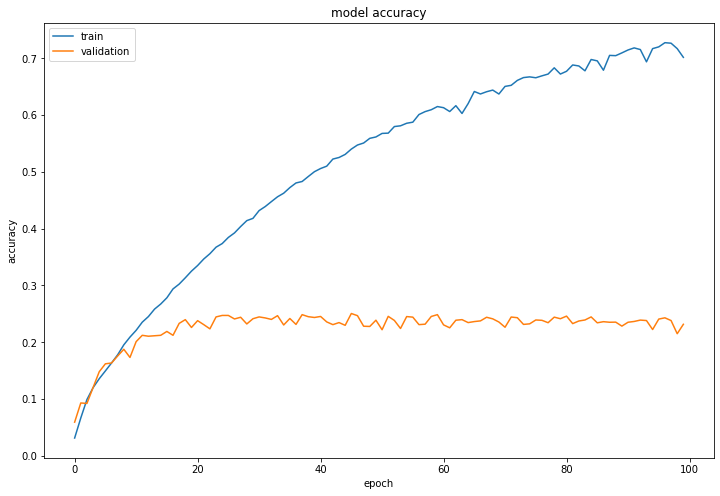

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

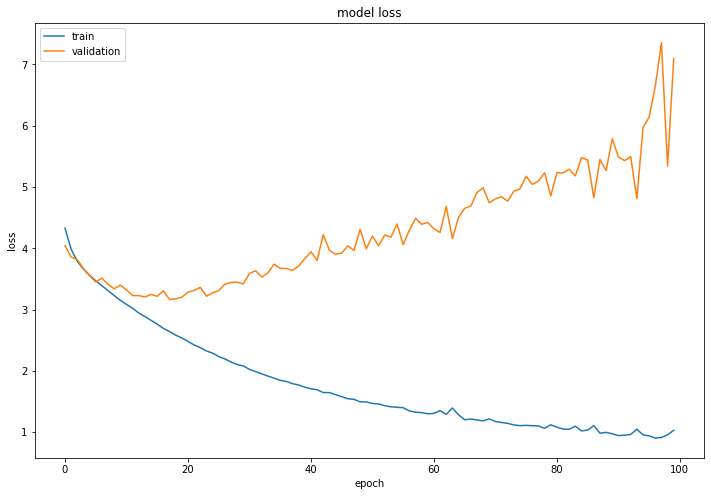

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

We can then make predictions and evaluate the model. 

In [41]:
from sklearn.metrics import accuracy_score

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(AlexNet.predict(X_test), axis=1)

# report accuracy score of the model
score = accuracy_score(y_pred, y_true)
print("The accuracy score of our model is", score)

The accuracy score of our model is 0.2446
